In [55]:
import numpy as np
import scipy as sp
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from time import time as timer
import Branching_Process as bp
import pandas as pd
from tqdm import tqdm
import importlib
import seaborn as sns
from joblib import Parallel, delayed
import os

sns.set_palette('Set2')
cmap = sns.color_palette('Set2')

In [94]:
Tmax = 200
time_step = 0.5
nsteps = int(Tmax / time_step) +1
time = np.linspace(0, Tmax, num=nsteps)
time_step = time[1] - time[0]
beta_test = 2/7
gamma_test = 1/7
omega = beta_test + gamma_test
growth_rate = beta_test - gamma_test
R_eff = 3
t_lockdown = 30


eta = 0.2

a = 6
b = 0.833


# Define distributions for the lifetime, infectivity profile and population-level transmission rate
# For Crump-Mode-Jagers Process

def lifetime(t):
    return sp.stats.gamma.cdf(t, a = a, scale = b) # sp.stats.expon.cdf(t, scale = 1/gamma_test)

def lifetime_pdf(t):
    return sp.stats.gamma.pdf(t, a = a, scale = b) # sp.stats.expon.pdf(t, scale = 1/gamma_test)

def infectiousness(t):
    return sp.stats.gamma.cdf(t, a = a, scale = b)

def infectiousness_pdf(t):
    return sp.stats.gamma.pdf(t, a = a, scale = b)

#def Rt(t, R=R_eff):
#    return R
Rt = 3 * np.ones_like(time)


In [90]:
def Poisson_generator(Rt, infectiousness, h):
        Poissons = np.random.poisson(Rt * infectiousness * h)
        return Poissons

In [91]:
nsims = 100

def CMJsimulate(nsims, time, infectiousness, Z0, Zstar = 167):
    nsteps = len(time)
    h = time[1]-time[0]
    Z=np.zeros((nsims, int(nsteps)))
    Z[:, 0] = Z0
    

    tstops = np.zeros(nsims)
    #nintervals = int(T/h)
    for i in tqdm(range(nsims)):
        for t in range(len(time)):
            nlifetimes = int(Z[i, t])
            lifetimes = (np.random.gamma(a, b, size = nlifetimes))
            intervals = t + lifetimes 
            diff = (intervals + 1) % h 
            recoveries = ((intervals - diff)/h).astype(int)
            #print(len(recoveries))
            if len(recoveries) == 0:
                continue
                
            
            for r in recoveries:
                #print(t, r)
                if nsteps > t + r:
                    Rs = Rt[(t+1):(t+r)]
                    iss = infectiousness(time)[:r-1]
                    new_infecteds = Poisson_generator(Rs, iss, h)
                    #print(len(Rs), len(iss))
                    Z[i, (t+1):(t+r)] += new_infecteds
                else:
                    
                    Rs = Rt[(t+1):]
                    assert(len(Rt) == len(Z[i,:]))
                    iss = infectiousness(time)[:-(t+1)]
                    new_infecteds = Poisson_generator(Rs, iss, h)
                    #print(len(Rs), len(iss))
                    Z[i, (t+1):] += new_infecteds
            if Z[i, t] > Zstar:
                tstops[i] = time[t]
                break
    return tstops

tbeeps = CMJsimulate(nsims, time, infectiousness, 1)

100%|██████████| 100/100 [00:03<00:00, 27.16it/s]


In [92]:
tbeeps

array([ 0. , 27. ,  0. ,  0. ,  0. ,  0. , 28. ,  0. ,  0. , 27. ,  0. ,
       26.5,  0. , 35. ,  0. , 25. , 28. , 24.5,  0. ,  0. , 26.5,  0. ,
       34. ,  0. ,  0. ,  0. ,  0. , 30. , 26.5, 27.5, 31. ,  0. ,  0. ,
       25.5, 28.5, 30. ,  0. , 25. , 32. ,  0. , 28. , 29. ,  0. , 30. ,
        0. , 31.5,  0. , 28. ,  0. ,  0. ,  0. , 29. ,  0. ,  0. ,  0. ,
        0. , 28. ,  0. ,  0. ,  0. ,  0. ,  0. , 29.5,  0. ,  0. , 25.5,
       27. ,  0. ,  0. ,  0. ,  0. , 31.5,  0. , 29. ,  0. , 27.5,  0. ,
       26. ,  0. ,  0. , 28.5,  0. ,  0. ,  0. , 32. , 32.5, 29. ,  0. ,
        0. , 26.5,  0. , 29. , 29. , 25. ,  0. ,  0. ,  0. , 26. , 28.5,
        0. ])

<Axes: ylabel='Density'>

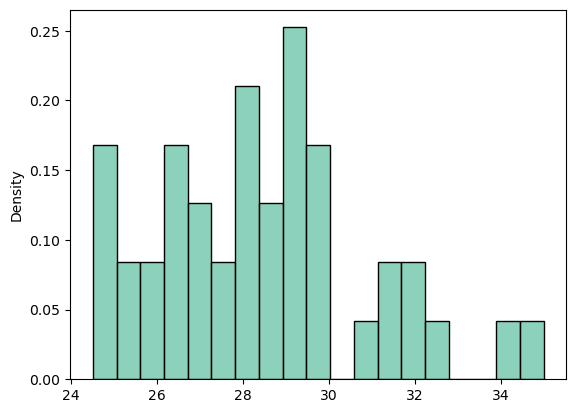

In [93]:
sns.histplot(tbeeps[tbeeps!=0], stat = 'density', bins = len(np.unique(tbeeps)))

0.20000000000000007